## Dependencies

In [1]:
import torch
from torch import nn

import torchaudio.transforms as T
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt

from IPython.display import Audio, display
from data.datasets import TIMITDataset
from utils.utils import set_seed

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


## Checking CUDA device and setting constant seed value

In [2]:
set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

## Datasets

In [5]:
vowel_labels = ['IY', 'IH', 'EH', 'EY', 'AE', 'AA', 'AW', 'AY', 'AH', 'AO', 'OY', 'OW', 'UH', 'UW', 'UX', 'ER', 'AX',
                'IX', 'AXR', 'AH-H']
consonant_labels = ['B', 'D', 'G', 'P', 'T', 'K', 'DX', 'Q',
                    'JH', 'CH', 'S', 'SH', 'Z', 'ZH', 'F', 'TH', 'V', 'M', 'N', 'NG', 'EM', 'EN', 'ENG', 'NX']
phone_labels = vowel_labels + consonant_labels

timit_dataset_train = TIMITDataset(usage='train', root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                   phone_codes=phone_labels, padding=16000,
                                   description_file_path='../../data/timit_description.csv')

timit_dataset_test = TIMITDataset(usage='test', root_dir='/media/maxim/Programming/voice_datasets/timit/TIMIT_2/data',
                                  phone_codes=phone_labels, padding=16000,
                                  description_file_path='../../data/timit_description.csv')

timit_framerate = timit_dataset_train[0].frame_rate

In [6]:
# labels = sorted(list(set(datapoint.label for datapoint in timit_dataset_train)))
# num_of_classes = len(labels)

In [7]:
labels = ['AA',
          'AE',
          'AH',
          'AO',
          'AW',
          'AX',
          'AXR',
          'AY',
          'B',
          'CH',
          'D',
          'DX',
          'EH',
          'EM',
          'EN',
          'ENG',
          'ER',
          'EY',
          'F',
          'G',
          'IH',
          'IX',
          'IY',
          'JH',
          'K',
          'M',
          'N',
          'NG',
          'NX',
          'OW',
          'OY',
          'P',
          'Q',
          'S',
          'SH',
          'T',
          'TH',
          'UH',
          'UW',
          'UX',
          'V',
          'Z',
          'ZH']
num_of_classes = len(labels)

## Initialization the preprocessing pipeline (torchaudio.transforms)

S


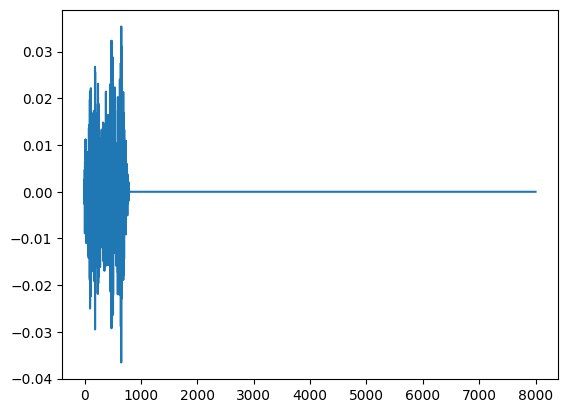

In [13]:
transform = T.Resample(orig_freq=timit_framerate, new_freq=8000)

item = 10
timit_waveform = timit_dataset_train[item].data
print(timit_dataset_train[item].label)

transformed = transform(timit_waveform)
display(Audio(transformed.numpy(), rate=8000))
plt.plot(transformed.t().numpy());

## Initializing Dataloaders

In [8]:
def label_to_index(phone):
    return torch.tensor(labels.index(phone))


def index_to_label(index):
    return labels[index]


def pad_sequence(batch):
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch):
    tensors, targets = [], []

    for waveform, label, *_ in batch:
        tensors += [waveform]
        targets += [label_to_index(label)]

    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 256

if device == "cuda":
    num_workers = 12
    pin_memory = True
else:
    num_workers = 12
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    timit_dataset_train,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)
test_loader = torch.utils.data.DataLoader(
    timit_dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory,
)

train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(transformed.shape[0])

EY --> tensor(17) --> EY
Feature batch shape: torch.Size([256, 1, 16000])
Labels batch shape: torch.Size([256])
1


## Phoneme recognizer

In [9]:
from models.m_models import M3, M11
from models.phoneme_recognizer import PhonemeRecognizer, AudioPreprocessorCallback

m11 = PhonemeRecognizer(
    num_classes=num_of_classes,
    acoustic_model=M11,
    model_params=dict(n_input=1, n_output=num_of_classes, stride=4, n_channel=256),
    loss_criterion=nn.NLLLoss(),
    lr=3e-1
)

preprocessor_callback = AudioPreprocessorCallback(transform=transform)

/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'loss_criterion' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss_criterion'])`.
  rank_zero_warn(
/home/maxim/VisibleSpeech/PhonemeRecognizer/venv/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Torchmetrics v0.9 introduced a new argument class property called `full_state_update` that has
                not been set for this class (NLLossTorchMetric). The property determines if `update` by
                default needs access to the full metric state. If this is not the case, significant speedups can be
                achieved and we recommend setting this to `False`.
                We provide an checking function
                `from torchmetrics.utilities import check_forward_full_state_property`
       

In [10]:
# class M33(pl.LightningModule):
#     def __init__(self, transform, n_input=1, n_output=num_of_classes, stride=4, n_channel=256):
#         super().__init__()
#         self.transform = transform
#         self.train_acc = torchmetrics.Accuracy()
#         self.valid_acc = torchmetrics.Accuracy()
#         self.conv1 = nn.Conv1d(n_input, n_channel, kernel_size=80, stride=stride)
#         self.bn1 = nn.BatchNorm1d(n_channel)
#         self.pool1 = nn.MaxPool1d(4)
#         #
#         self.conv2 = self.conv2 = nn.Conv1d(n_channel, n_channel, kernel_size=3)
#         self.bn2 = nn.BatchNorm1d(n_channel)
#         self.pool2 = nn.MaxPool1d(4)
#
#         self.fc1 = nn.Linear(n_channel, n_output)
#
#         self.model_idx = 0
#
#     def custom_histogram_adder(self):
#         for name,params in self.named_parameters():
#             self.logger.experiment.add_histogram(name, params, self.current_epoch)
#
#
#     def forward(self, x):
#         x = self.conv1(x)
#         x = F.relu(self.bn1(x))
#         x = self.pool1(x)
#         x = self.conv2(x)
#         x = F.relu(self.bn2(x))
#         x = self.pool2(x)
#
#         x = F.avg_pool1d(x, x.shape[-1])
#         x = x.permute(0, 2, 1)
#         x = self.fc1(x)
#         return F.log_softmax(x, dim=2)
#
#     def training_step(self, batch, batch_idx):
#         data, target = batch
#         data = self.transform(data)
#         output = self.forward(data)
#         self.train_acc(output.squeeze(), target)
#         loss = F.nll_loss(output.squeeze(), target)
#         self.log('train_acc', self.train_acc, on_step=True, on_epoch=False)
#         self.log('train_loss', loss)
#
#         self.custom_histogram_adder()
#
#         return loss
#
#     def validation_step(self, batch, batch_idx):
#         data, target = batch
#         data = self.transform(data)
#         output = self.forward(data)
#         self.valid_acc(output.squeeze(), target)
#         loss = F.nll_loss(output.squeeze(), target)
#         self.log('valid_acc', self.valid_acc, on_step=True, on_epoch=True)
#         self.log('train_loss', loss)
#         return loss
#
#
#     def configure_optimizers(self):
#         optimizer = torch.optim.Adam(self.parameters(), lr=1e-1)
#         return optimizer

In [11]:
model = m11

# data, target = next(iter(train_loader))
# data = data.to('cuda')
# target = target.to('cuda')
# model(transform(data)).shape, target

In [15]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

model_name = 'M11'
logger = TensorBoardLogger('../../logs', name=model_name, log_graph=False, default_hp_metric=False)

In [13]:
% reload_ext tensorboard
% tensorboard --logdir '../../logs'

Launching TensorBoard...

In [16]:
n_epochs = 50

trainer = pl.Trainer(
    logger=logger,
    accelerator="gpu",
    devices=1,
    callbacks=preprocessor_callback,
    max_epochs=n_epochs,
    log_every_n_steps=10)
trainer.fit(model, train_loader, test_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: ../../logs/M11
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name               | Type             | Params
--------------------------------------------------------
0 | acoustic_model     | M11              | 28.4 M
1 | loss_criterion     | NLLLoss          | 0     
2 | train_metrics      | MetricCollection | 0     
3 | val_metrics        | MetricCollection | 0     
4 | test_metrics       | MetricCollection | 0     
5 | checkpoint_metrics | MetricCollection | 0     
--------------------------------------------------------
28.4 M    Trainable params
0         Non-trainable params
28.4 M    Total params
113.788   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
